In [81]:
import os
import random
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The device used is : {device}')

import warnings
warnings.filterwarnings('ignore')

The device used is : cuda


In [53]:
path = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'
images_path = []
labels = []

for subset in os.listdir(path):
    for label in os.listdir(os.path.join(path, subset)):
        for image in os.listdir(os.path.join(path, subset, label)):
            images_path.append(os.path.join(path, subset, label, image))
            labels.append(label)

data = pd.DataFrame({
    'images_path': images_path,
    'labels': labels
})
print(f'Dataset lenght : {len(data)}')
data.head()

Dataset lenght : 87867


images_path                labels
0  /kaggle/input/new-plant-diseases-dataset/New P...  Tomato___Late_blight
1  /kaggle/input/new-plant-diseases-dataset/New P...  Tomato___Late_blight
2  /kaggle/input/new-plant-diseases-dataset/New P...  Tomato___Late_blight
3  /kaggle/input/new-plant-diseases-dataset/New P...  Tomato___Late_blight
4  /kaggle/input/new-plant-diseases-dataset/New P...  Tomato___Late_blight

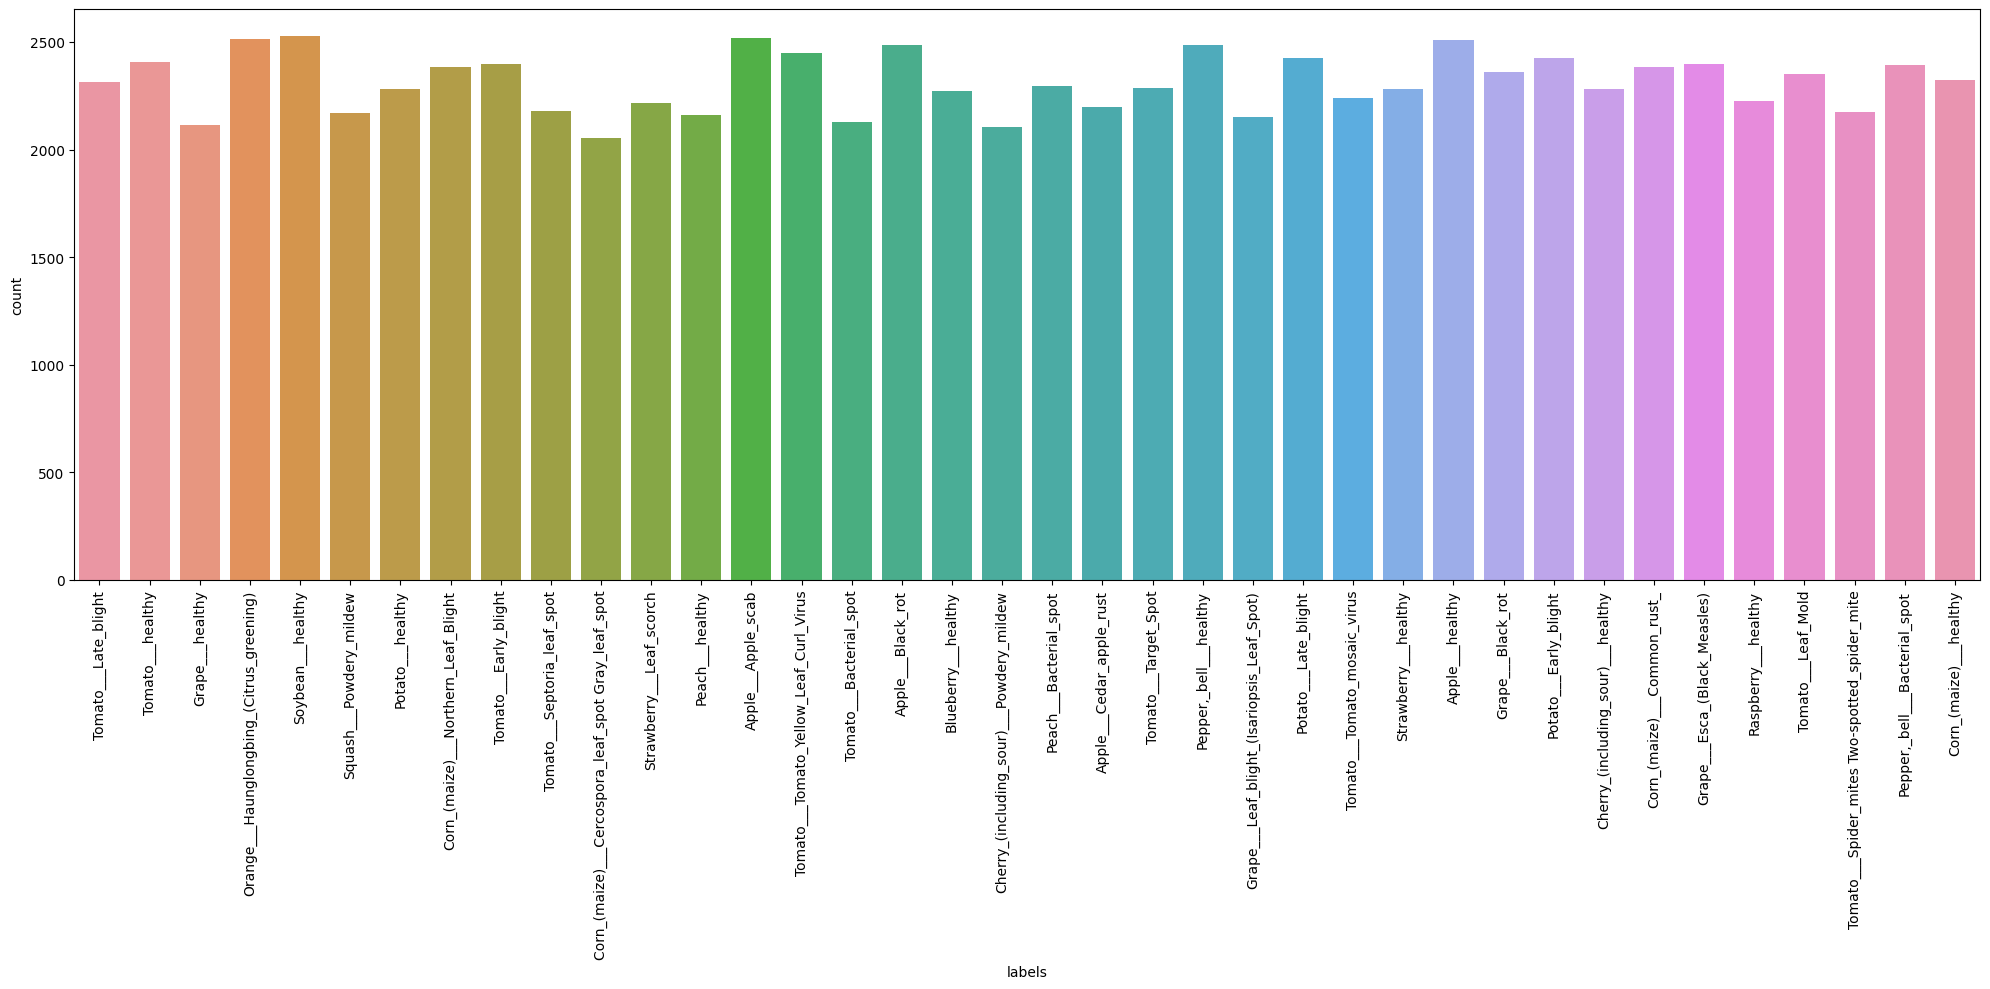

In [26]:
plt.figure(figsize = (20, 10))

sns.countplot(data = data, x = 'labels')
plt.xticks(rotation = 90)

plt.tight_layout()
plt.show()

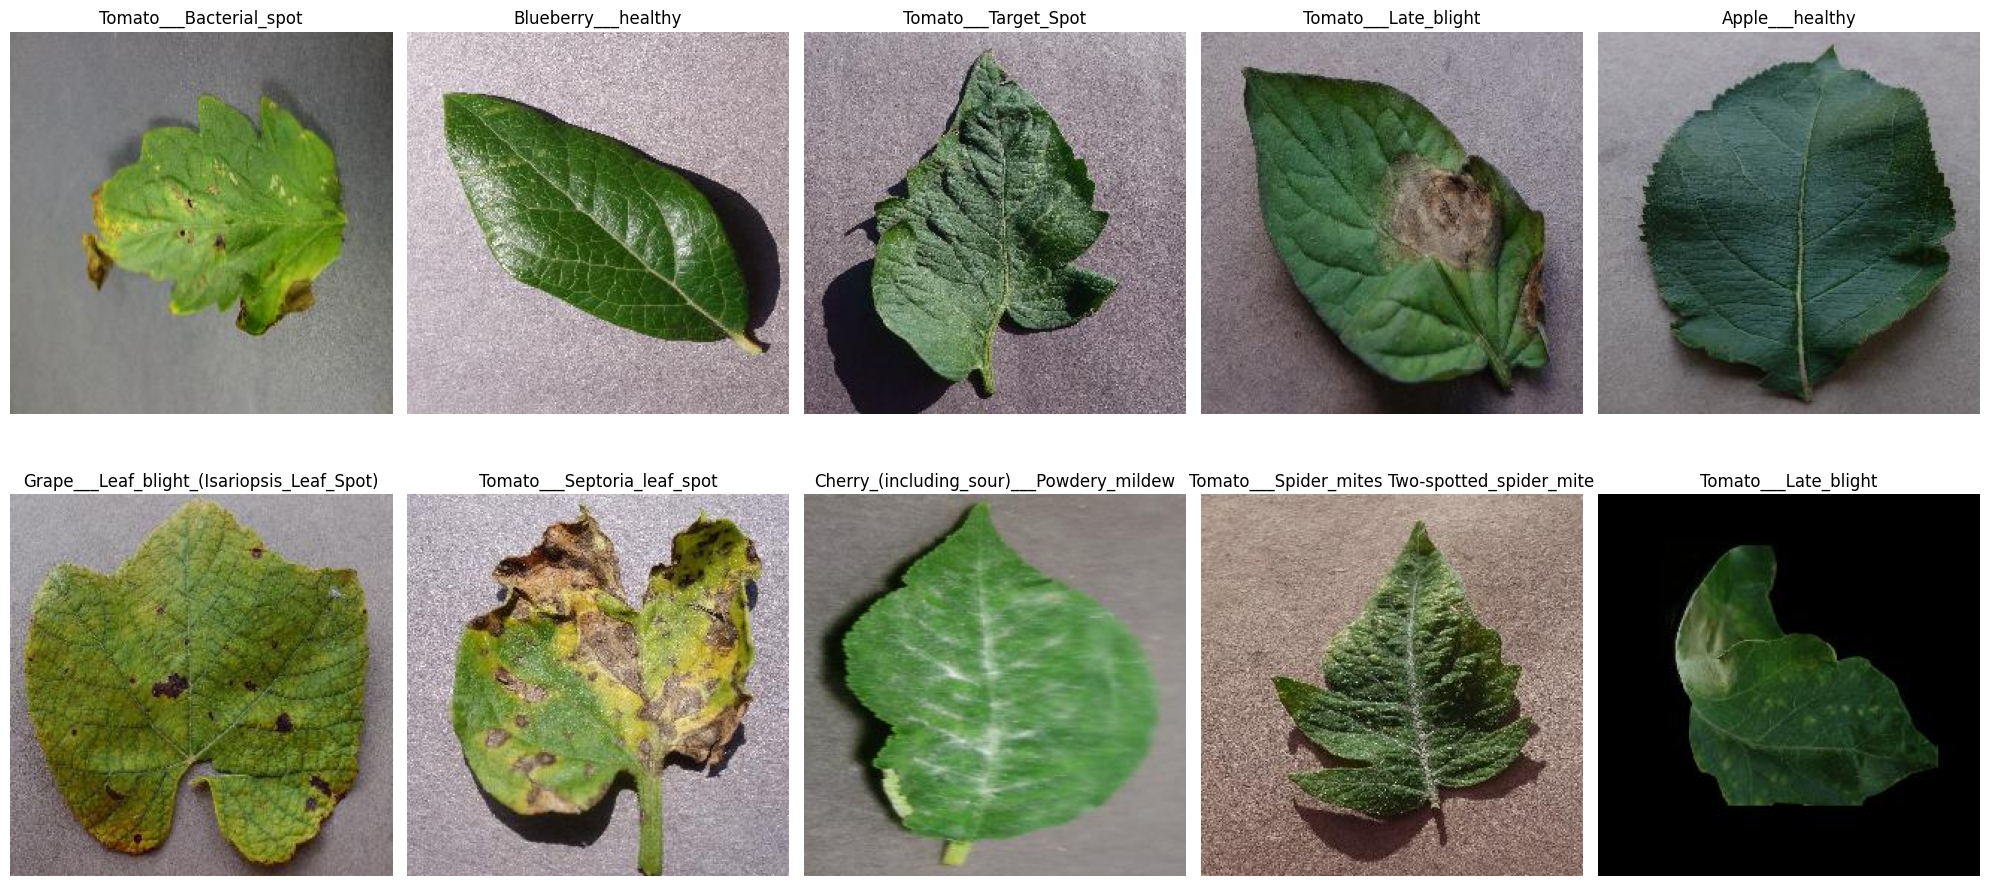

In [37]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))

for row in range(2):
    for column in range(5):
        sample = data.sample(n = 1)
        image = Image.open(sample['images_path'].values[0])
        label = sample['labels'].values[0]

        axes[row, column].imshow(image)
        axes[row, column].set_title(label)
        axes[row, column].axis('off')

plt.tight_layout()
plt.show()

In [54]:
class StandardNormalize:
    def __init__(self):
        pass

    def __call__(self, image):
        if isinstance(image, torch.Tensor):
            image_np = image.numpy()
        else:
            image_np = np.array(image)

        norm_channels = []
        for c in range(image_np.shape[0]):
            mean = np.mean(image_np[c])
            std = np.std(image_np[c]) + 1e-8
            norm = (image_np[c] - mean) / std
            norm_channels.append(norm)

        norm_img = np.stack(norm_channels, axis = 0)
        return torch.tensor(norm_img, dtype = torch.float32)

In [ ]:
encoder = LabelEncoder()
encoder.fit(data['labels'])
print(encoder.classes_)

transform = transforms.Compose([
    transforms.Resize((128, 128)),                   # Resize standard
    transforms.RandomResizedCrop(128),               # Crop aléatoire pour aider à la généralisation
    transforms.RandomHorizontalFlip(),               # Flip gauche-droite
    transforms.RandomRotation(15),                   # Rotation légère (feuilles peuvent bouger)
    transforms.ColorJitter(brightness = 0.3, contrast = 0.3, saturation = 0.3),  # Variations d’éclairage
    transforms.ToTensor(),                           # Passage au format tensor
    StandardNormalize(),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    StandardNormalize(),
])

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tom

In [56]:
train = data.sample(frac = 0.7)
test = data.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(f'Length of Trainset : {len(train)}')
print(f'Length of Valset : {len(val)}')
print(f'Length of Testset : {len(test)}')

Length of Trainset : 61507
Length of Valset : 13180
Length of Testset : 13180


In [69]:
class PlantDiseasesDataset(Dataset):
    def __init__(self, data, transform = None):
        self.data = data.reset_index(drop = True)
        self.data = data
        self.transform = transform
        self.labels = torch.tensor(encoder.transform(data['labels'])).to(device)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data['images_path'].iloc[index]
        image = Image.open(image).convert('RGB')

        label = self.labels[index]

        if transform:
            image = self.transform(image).to(device)

        return image, label

In [70]:
train_dataset = PlantDiseasesDataset(data = train, transform = transform)
val_dataset = PlantDiseasesDataset(data = val, transform = val_transform)
test_dataset = PlantDiseasesDataset(data = test, transform = val_transform)

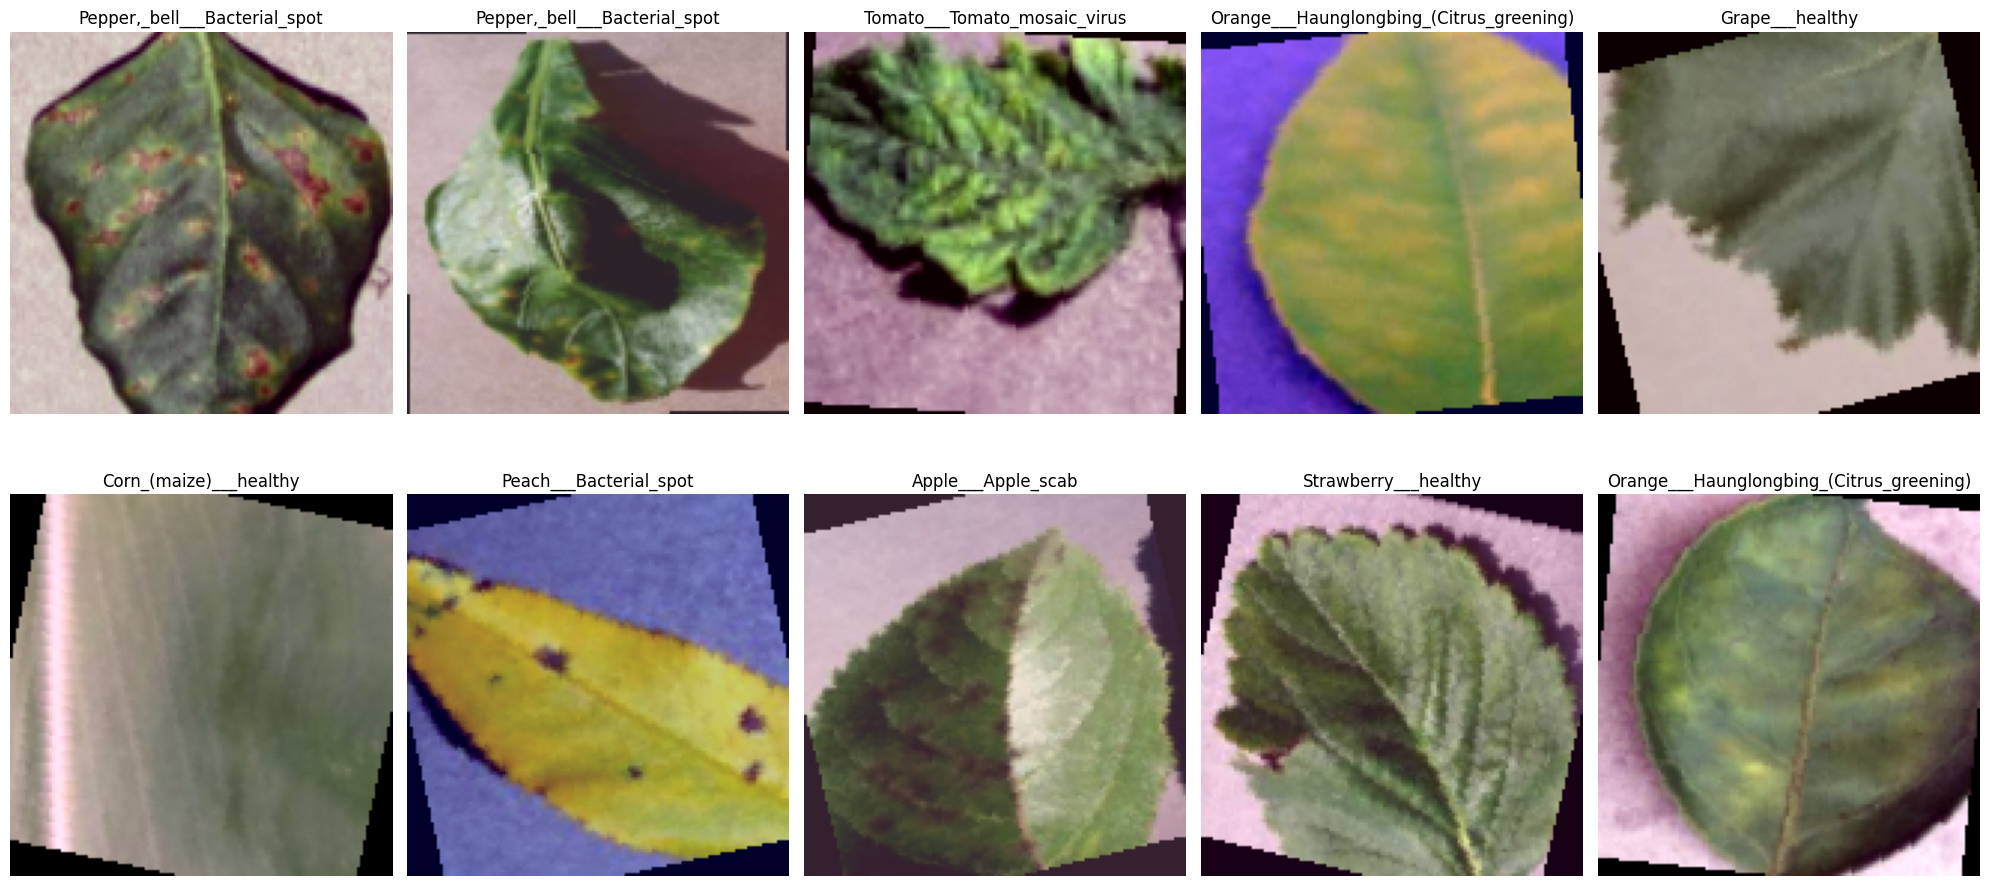

In [71]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))

random_indices = random.sample(range(len(train_dataset)), 10)

for ax, index in zip(axes.flat, random_indices):
    image, label = train_dataset[index]
    image = image.permute(1, 2, 0).cpu().numpy()

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = image * std + mean  # dé-normalisation
    image = image.clip(0, 1)

    ax.imshow(image)
    ax.set_title(encoder.classes_[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [72]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

In [73]:
class PlantDiseasesDetector(nn.Module):
    def __init__(self, num_classes = len(encoder.classes_)):
        super(PlantDiseasesDetector, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1)
        self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)

        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.linear = nn.Linear(in_features = 512 * 4 * 4, out_features = 512)
        self.output = nn.Linear(in_features = 512, out_features = num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.pool(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.pool(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.pool(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.pool(x)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        
        output = self.output(x)
        return output

In [74]:
model = PlantDiseasesDetector().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 1e-3)
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 256, 16, 16]         295,168
        MaxPool2d-11            [-1, 256, 8, 8]               0
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 8, 8]       1,180,160
        MaxPool2d-14            [-1, 51

In [75]:
def train_model(train_loader, val_loader, model = model, criterion = criterion, optimizer = optimizer, device = device, epochs = 10):
    history = {
        'train_loss': [],
        'train_acc': [],
        'train_f1': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }

    for epoch in range(epochs):
        model.train()
        train_loss, train_preds, train_labels = 0.0, [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)

            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_acc = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average = 'weighted')

        model.eval()
        val_loss, val_preds, val_labels = 0.0, [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)

                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average = 'weighted')

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        print(f'Epoch {epoch + 1}/{epochs}')
        print(f'  Training   Loss : {avg_train_loss:.4f} | Accuracy : {train_acc:.4f} | F1 : {train_f1:.4f}')
        print(f'  Validation Loss : {avg_val_loss:.4f}   | Accuracy : {val_acc:.4f}   | F1 : {val_f1:.4f}')
        print('-' * 50)

    return history

In [64]:
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize = (15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label = 'Train Loss')
    plt.plot(epochs, history['val_loss'], label = 'Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label = 'Train Accuracy')
    plt.plot(epochs, history['val_acc'], label = 'Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_f1'], label = 'Train F1')
    plt.plot(epochs, history['val_f1'], label = 'Validation F1')
    plt.title('F1 Score over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [83]:
def validate_model(data_loader, model = model, device = device, class_names = encoder.classes_, plot_cm = False):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average = 'weighted')
    print(f'\n Accuracy: {acc:.4f}')
    print(f' F1-score: {f1:.4f}\n')

    print('Classification Report :')
    print(classification_report(all_labels, all_preds, target_names = class_names))

    if plot_cm:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize = (20, 10))
        sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()

In [77]:
def predict_label(image, model = model, device = device):
    image = Image.open(image).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predictions = torch.max(outputs, 1)
    
    return predictions.item()

In [78]:
history = train_model(train_loader, val_loader)

Epoch 1/10
  Training   Loss : 2.1877 | Accuracy : 0.3755 | F1 : 0.3717
  Validation Loss : 1.4562   | Accuracy : 0.5549   | F1 : 0.5468
--------------------------------------------------
Epoch 2/10
  Training   Loss : 1.2003 | Accuracy : 0.6405 | F1 : 0.6382
  Validation Loss : 0.9045   | Accuracy : 0.7077   | F1 : 0.7109
--------------------------------------------------
Epoch 3/10
  Training   Loss : 0.9938 | Accuracy : 0.7012 | F1 : 0.6998
  Validation Loss : 0.7750   | Accuracy : 0.7596   | F1 : 0.7610
--------------------------------------------------
Epoch 4/10
  Training   Loss : 0.8819 | Accuracy : 0.7348 | F1 : 0.7339
  Validation Loss : 0.8165   | Accuracy : 0.7439   | F1 : 0.7462
--------------------------------------------------
Epoch 5/10
  Training   Loss : 0.8286 | Accuracy : 0.7477 | F1 : 0.7467
  Validation Loss : 0.7007   | Accuracy : 0.7813   | F1 : 0.7879
--------------------------------------------------
Epoch 6/10
  Training   Loss : 0.7958 | Accuracy : 0.7595 | 

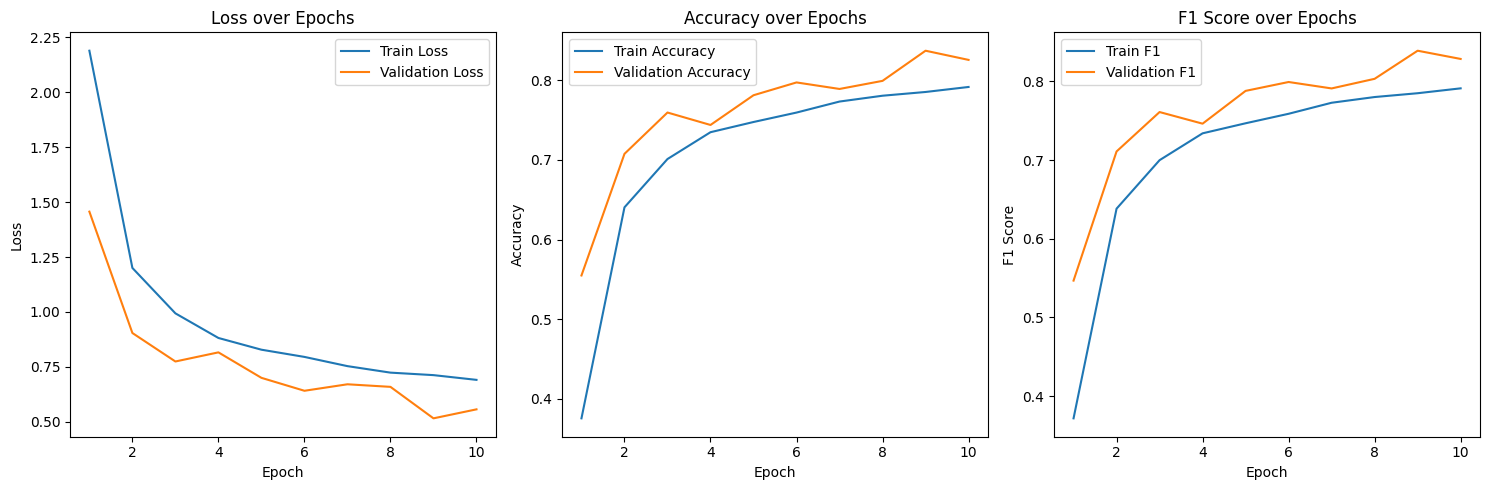

In [79]:
plot_training_curves(history)

In [84]:
validate_model(test_loader)


 Accuracy: 0.8225
 F1-score: 0.8257

Classification Report :
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.83      0.87      0.85       377
                                 Apple___Black_rot       0.96      0.77      0.86       379
                          Apple___Cedar_apple_rust       0.79      0.85      0.82       341
                                   Apple___healthy       0.60      0.91      0.73       380
                               Blueberry___healthy       0.56      0.94      0.70       343
          Cherry_(including_sour)___Powdery_mildew       0.98      0.76      0.86       300
                 Cherry_(including_sour)___healthy       0.96      0.72      0.82       346
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.75      0.93      0.83       319
                       Corn_(maize)___Common_rust_       0.98      0.99      0.98       345
               Co